### Stroke Work poisson Regression 
<br>Author: Daniel Maina Nderitu<br>
Project: MADIVA

In [559]:
# !pip install seaborn

### Import libraries

In [560]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
import os

from openpyxl.workbook import Workbook

# see all variables
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Optional: Set working directory to where your data and outputs will go
os.chdir(r"D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work")
# Ensure directories exist
os.makedirs("model_output", exist_ok=True)
os.makedirs("visualization", exist_ok=True)

### Load data

In [561]:
# Load your cleaned dataset
df_raw = pd.read_csv("D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/data/cleaned_df.csv")
df = df_raw.copy()
print(df.shape)
# df.head(3)

(47405, 109)


### Data preprocessing

In [562]:
print(df.sex.value_counts())
df['sex_binary'] = df['sex'].replace({1: 0, 2: 1})  # 0 = male, 1 = female
df['bmi_refined'] = pd.to_numeric(df['bmi_refined'], errors='coerce')
# Based on WHO categories
df['bmi_category'] = pd.cut(df['bmi_refined'], 
                            bins=[0, 18.5, 24.9, 29.9, np.inf], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df = pd.get_dummies(df, columns=['bmi_category'], drop_first=True)
# Convert all boolean columns to integers (0/1)
df = df.astype({col: int for col in df.select_dtypes(bool).columns})
print(df.sex_binary.value_counts())

sex
2    26556
1    20849
Name: count, dtype: int64
sex_binary
1    26556
0    20849
Name: count, dtype: int64


In [563]:
# Filtering to see if the columns exists
df.filter(like='bmi_category').head()

,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese
0,0,0,0
1,0,1,0
2,0,0,1
3,0,0,0
4,0,0,1


In [564]:
def assign_who_age_group_code(age):
    if pd.isnull(age):
        return 999  # 999 = Missing
    elif age < 15:
        return 1  # Children (0–14)
    elif age < 25:
        return 2  # Youth (15–24)
    elif age < 65:
        return 3  # Adults (25–64)
    else:
        return 4  # Elderly (65+)
# Apply the function to your DataFrame
df["age_group"] = df["age"].apply(assign_who_age_group_code)
# Optional: Map codes to readable labels
age_group_labels = {
    1: "Children (0–14)",
    2: "Youth (15–24)",
    3: "Adults (25–64)",
    4: "Elderly (65+)",
    999: "Missing"
}
df["who_age_group"] = df["age_group"].map(age_group_labels)
# ---------------------------------------------------------------------------
cat_cols = ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived',
            'obese_status_derived', 'diab_status_derived',
            'hiv_status_derived', 'tb_status_derived']
for col in cat_cols:
    df[col] = df[col].astype('category').cat.add_categories('Missing').fillna('Missing')
numeric_cols = ['bmi_refined']
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))
# Exclude irrelevant values
df = df.replace([333, 444, 888, 999], np.nan)
df = df.replace([-333, -444, -888, -999], np.nan)

C:\Users\dmaina\AppData\Local\Temp\ipykernel_18784\3122740068.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["age_group"] = df["age"].apply(assign_who_age_group_code)
C:\Users\dmaina\AppData\Local\Temp\ipykernel_18784\3122740068.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["who_age_group"] = df["age_group"].map(age_group_labels)
C:\Users\dmaina\AppData\Local\Temp\ipykernel_18784\3122740068.py:32: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a fu

In [565]:
# ---------------------------------------------------------------------------
# Handle site variable (ONE-HOT ENCODING)
# ---------------------------------------------------------------------------
# Make sure 'hdss_name' exists and is string
df['hdss_name'] = df['hdss_name'].astype(str)
 
# One-hot encode site (drop one to avoid multicollinearity)
site_dummies = pd.get_dummies(df['hdss_name'], prefix='site', drop_first=True)

# Merge dummy columns into df
df = pd.concat([df, site_dummies], axis=1)
df['site_Nairobi'] = df['site_Nairobi'].astype('category')
# df['site_Agincourt'] = df['site_Agincourt'].astype('category')
print("Site dummy variables created:", list(site_dummies.columns))
# df.head(3)

Site dummy variables created: ['site_Nairobi']


#### To integer type

In [566]:
df.site_Nairobi = df.site_Nairobi.astype(int)

df.bmi_category_Normal = df.bmi_category_Normal.astype(int)
df.bmi_category_Overweight = df.bmi_category_Overweight.astype(int)
df.bmi_category_Obese = df.bmi_category_Obese.astype(int)
# df.hdss_name.value_counts()

### Treatment to ensure we don't inflate incidence

In [567]:
print("Before")
print(df.shape)
df = df.sort_values(['individual_id', 'obs_date'])

# ---------------------------------------------------------------------------
# Sort and prepare time intervals
df['age_start'] = df.groupby('individual_id')['age'].shift(0)
df['age_end'] = df.groupby('individual_id')['age'].shift(-1)

# ---------------------------------------------------------------------------
# Define the event (stroke occurrence)
df['stroke_prev'] = df.groupby('individual_id')['stroke_status_derived'].shift(1)
df['event'] = np.where((df['stroke_prev'] == 0) & (df['stroke_status_derived'] == 1), 1, 0)
df['event'] = df['event'].fillna(0)

# ---------------------------------------------------------------------------
# Compute time at risk
df['time_at_risk'] = df['age_end'] - df['age_start']
df['time_at_risk'] = df['time_at_risk'].fillna(2)  # Filling with an average followup of 2 year / we can change this

# ---------------------------------------------------------------------------
# find first event per person  (different from prevalence)
df['cumulative_stroke'] = df.groupby('individual_id')['stroke_status_derived'].cumsum()

# ---------------------------------------------------------------------------
# keep only records before or up to the first stroke
df = df[df['cumulative_stroke'] <= 1]
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------
# Convert your numeric columns properly
df = df.apply(pd.to_numeric, errors='coerce')

print("after")
print(df.shape)
df.head()

Before
(47405, 116)
after
(45842, 122)


,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,tb_status_derived_age,obese_status_derived_age,hiv_status_derived_age,sex_binary,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_group,who_age_group,site_Nairobi,age_start,age_end,stroke_prev,event,time_at_risk,cumulative_stroke
0,NaN,35,NaN,2,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,12.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,99.0,58.0,4.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,27.3,0,NaN,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,0,0,3,NaN,1,35,39.0,NaN,0,4.0,0.0
1,NaN,39,NaN,2,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,7.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,25.9187,25.9,0,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,1,0,3,NaN,1,39,NaN,0.0,0,2.0,0.0
2,NaN,36,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7.0,5.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,NaN,31.1690,31.2,0,0.0,0.0,36.0,36.0,36.0,36.0,36.0,36.0,0,0,0,1,3,NaN,1,36,NaN,NaN,0,2.0,0.0
3,NaN,56,NaN,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,11.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,3.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,113.0,73.0,5.8,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,27.3,0,NaN,0.0,61.0,56.0,61.0,61.0,61.0,61.0,0,0,0,0,3,NaN,1,56,61.0,NaN,0,5.0,0.0
4,NaN,61,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7.0,7.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Create offset and covariates

In [568]:
df['offset'] = np.log(df['time_at_risk'])

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Covariates and dealing with infinite values

In [569]:
# How to deal with missing / infinite values before running the model
# # Option 1 (drop missing values)
# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.dropna()

# Option 2
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)  # or use .fillna(df.mean()) if numeric

covariates = ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived'
              , 'diab_status_derived','bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese'
              ,'hiv_status_derived', 'tb_status_derived'] + list(site_dummies.columns)
# 'sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_refined','hiv_status_derived', 'tb_status_derived'
print(df.offset.describe())
df.head()  # Checking something

count    45842.000000
mean         0.766608
std          0.426914
min          0.000000
25%          0.693147
50%          0.693147
75%          1.098612
max          2.079442
Name: offset, dtype: float64


,individual_id,age,dod,sex,obs_date,source,hdss_name,alco_ever,alco_12m,alco_30d,alco_bing_y,tobac_ever,tobac_cur,tobac_smkls_ever,tobac_p_daily,tobac_freq,fd_fruitservings,fd_meals_outhome_ave,fd_diet_change,fd_fruit_days,fd_veg_days,fd_eat_drink_12h,fd_oil_type,fd_veg_servings,actv_walk_bicycle_days,actv_vigorous_sports_min,actv_mpa_minutes,actv_moderate_sports_hrs,actv_vigorous_sports,actv_mpa_days,actv_vpa_days,actv_sitting_or_standing,actv_walk_bicycle_min,actv_vpa_hrs,actv_walk_bicycle_hrs,actv_walk_bicycle,actv_moderate_sports_days,actv_mpa_hrs,actv_sitting_min,actv_moderate_sports_min,actv_sleeping_hrs,actv_vigorous_sports_days,actv_moderate_sports,actv_vpa_minutes,actv_vpa,actv_mpa,actv_vigorous_sports_hrs,actv_mvpa,actv_sitting_hrs,stroke_ever,stroke_numb,stroke_wkness,stroke_paralysis_ever,stroke_blind,stroke_trans_isc_ever,stroke_parents,stroke_sibling,stroke_other,stroke_children,stroke_fhx,hpt_ever,hpt_rx_ever,hpt_12m,bp_sys,bp_dia,bg_mmol_fst,bg_mmol_random,diab_hx,diab_12m,diab_rx_ever,diab_rx_current,diab_rx_other,diab_rx_2w,diab_rx_12m,diab_rx_trad_curr,diab_rx_other_2w,kidney_rx,pi_acr,stroke_undstn,stroke_verbal,vision_problem,stroke_hl_vis,sex_no_condom_hiv_person,hiv_tested_when_d,hiv_rx_trad_ever,hiv_counselled,hiv_tested,hiv_tested_when_c,hiv_tested_month,hiv_tested_yr,hiv_status_slf_rpt,hiv_test_result,stroke_status_derived,hiv_status_derived,hpt_status_derived,obese_status_derived,diab_status_derived,tb_status_derived,bmi,bmi_refined,is_outlier,alcohol_use,tobacco_use,stroke_status_derived_age,hpt_status_derived_age,diab_status_derived_age,tb_status_derived_age,obese_status_derived_age,hiv_status_derived_age,sex_binary,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,age_group,who_age_group,site_Nairobi,age_start,age_end,stroke_prev,event,time_at_risk,cumulative_stroke,offset
0,0.0,35,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.0,58.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,27.3,0,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,0,0,3,0.0,1,35,39.0,0.0,0,4.0,0.0,1.386294
1,0.0,39,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,7.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25.9187,25.9,0,0.0,0.0,39.0,39.0,39.0,39.0,39.0,39.0,1,0,1,0,3,0.0,1,39,0.0,0.0,0,2.0,0.0,0.693147
2,0.0,36,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,31.1690,31.2,0,0.0,0.0,36.0,36.0,36.0,36.0,36.0,36.0,0,0,0,1,3,0.0,1,36,0.0,0.0,0,2.0,0.0,0.693147
3,0.0,56,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.0,73.0,5.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0000,27.3,0,0.0,0.0,61.0,56.0,61.0,61.0,61.0,61.0,0,0,0,0,3,0.0,1,56,61.0,0.0,0,5.0,0.0,1.609438
4,0.0,61,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,7.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [570]:
# Ensure all columns used in the model are numeric
# X = df.drop(['stroke_status_derived', 'individual_id', 'obs_date'], axis=1, errors='ignore')
X = df[covariates]
y = df['stroke_status_derived']

non_numeric = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", list(non_numeric))

# Convert boolean columns to integers
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)# Convert to numeric (if any column is still object type)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Drop rows with missing values that result from coercion
X = X.dropna()
y = y.loc[X.index]

X = sm.add_constant(X)  # add constant term for intercept

model = sm.OLS(y, X).fit()
print(model.summary())

Non-numeric columns: []
                              OLS Regression Results                             
Dep. Variable:     stroke_status_derived   R-squared:                       0.011
Model:                               OLS   Adj. R-squared:                  0.011
Method:                    Least Squares   F-statistic:                     43.36
Date:                   Tue, 21 Oct 2025   Prob (F-statistic):          4.16e-103
Time:                           11:25:42   Log-Likelihood:                 21384.
No. Observations:                  45842   AIC:                        -4.274e+04
Df Residuals:                      45829   BIC:                        -4.263e+04
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [571]:
import numpy as np
import pandas as pd

# Check for NaN or inf
df.isna().sum()  # counts NaNs per column
np.isinf(df).sum()  # counts infinities per column

# Quick way to see how many bad values per column
(df.isna() | np.isinf(df)).sum()

individual_id        0
age                  0
dod                  0
sex                  0
obs_date             0
                    ..
stroke_prev          0
event                0
time_at_risk         0
cumulative_stroke    0
offset               0
Length: 123, dtype: int64

In [572]:
df[covariates].dtypes

sex_binary                   int64
alcohol_use                float64
tobacco_use                float64
hpt_status_derived         float64
obese_status_derived       float64
diab_status_derived        float64
bmi_category_Normal          int64
bmi_category_Overweight      int64
bmi_category_Obese           int64
hiv_status_derived         float64
tb_status_derived          float64
site_Nairobi                 int64
dtype: object

### Poisson regression model

In [573]:
import statsmodels.api as sm

model_pois = sm.GLM(
    df['event'],
    sm.add_constant(df[covariates]),
    family=sm.families.Poisson(),
    offset=df['offset']
).fit()

print(model_pois.summary())
print("\nIncidence Rate Ratios (IRR):")
print(np.exp(model_pois.params))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                45842
Model:                            GLM   Df Residuals:                    45829
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3226.4
Date:                Tue, 21 Oct 2025   Deviance:                       5198.7
Time:                        11:25:43   Pearson chi2:                 6.23e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01200
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### Poisson Model Results

In [574]:
import numpy as np
import pandas as pd

# Print full model summary
print(model_pois.summary())

# Create a tidy summary DataFrame
results_df = pd.DataFrame({
    "Variable": model_pois.params.index,
    "Coef": model_pois.params.values,
    "StdErr": model_pois.bse,
    "z": model_pois.tvalues,
    "P>|z|": model_pois.pvalues,
    "CI_lower": model_pois.conf_int()[0],
    "CI_upper": model_pois.conf_int()[1]
})

# Add Incidence Rate Ratios (IRR)
results_df["IRR"] = np.exp(results_df["Coef"])
results_df["IRR_CI_lower"] = np.exp(results_df["CI_lower"])
results_df["IRR_CI_upper"] = np.exp(results_df["CI_upper"])

# print(results_df)
results_df.to_csv("model_output/poisson_model_results.csv", index=False)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                45842
Model:                            GLM   Df Residuals:                    45829
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3226.4
Date:                Tue, 21 Oct 2025   Deviance:                       5198.7
Time:                        11:25:43   Pearson chi2:                 6.23e+04
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01200
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Three models

#### Standard Poisson Regression

In [575]:
model_pois = sm.GLM(y, X, family=sm.families.Poisson(), offset=df['offset']).fit()
model_robust = sm.GLM(y, X, family=sm.families.Poisson()).fit(cov_type='HC0')
model_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


#### Compare models side-by-side

In [576]:
summary = summary_col(
    results=[model_pois, model_robust, model_nb],
    model_names=['Poisson', 'Robust Poisson', 'NegBinomial'],
    stars=True,
    float_format='%0.3f',
    info_dict={'N':lambda x: f"{int(x.nobs)}"}
)
print(summary)


                         Poisson  Robust Poisson NegBinomial
------------------------------------------------------------
const                   -5.709*** -4.863***      -4.864***  
                        (0.096)   (0.091)        (0.096)    
sex_binary              -0.137**  -0.150**       -0.149**   
                        (0.061)   (0.060)        (0.062)    
alcohol_use             -0.464*** -0.475***      -0.474***  
                        (0.111)   (0.111)        (0.112)    
tobacco_use             0.184**   0.191**        0.193**    
                        (0.076)   (0.075)        (0.077)    
hpt_status_derived      1.176***  1.150***       1.152***   
                        (0.089)   (0.091)        (0.090)    
obese_status_derived    -0.699*** -0.498**       -0.495**   
                        (0.198)   (0.195)        (0.204)    
diab_status_derived     0.677***  0.645***       0.647***   
                        (0.074)   (0.073)        (0.076)    
bmi_category_Normal    

####  Compute and export IRRs for each model

In [577]:
def extract_irrs(model):
    df_irr = pd.DataFrame({
        "Variable": model.params.index,
        "Coef": model.params.values,
        "StdErr": model.bse,
        "z": model.tvalues,
        "P>|z|": model.pvalues,
        "CI_lower": model.conf_int()[0],
        "CI_upper": model.conf_int()[1]
    })
    df_irr["IRR"] = np.exp(df_irr["Coef"])
    df_irr["IRR_CI_lower"] = np.exp(df_irr["CI_lower"])
    df_irr["IRR_CI_upper"] = np.exp(df_irr["CI_upper"])
    # Add significance stars
    df_irr["sig"] = df_irr["P>|z|"].apply(lambda p: 
                                  "***" if p < 0.001 else 
                                  "**" if p < 0.01 else 
                                  "*" if p < 0.05 else "")
    return df_irr

results_pois = extract_irrs(model_pois)
results_robust = extract_irrs(model_robust)
results_nb = extract_irrs(model_nb)

# --- 4️⃣ Combine results for export ---
all_results = pd.concat([
    results_pois.assign(Model='Poisson'),
    results_robust.assign(Model='Robust Poisson'),
    results_nb.assign(Model='NegBinomial')
])

# Save table to Excel
all_results.to_excel("model_output/stroke_model_results_comparison.xlsx", index=False)
print("✅ Model comparison results saved to Excel.")

✅ Model comparison results saved to Excel.


### Addition - 21-Oct-2025

In [584]:
import statsmodels.api as sm

# model_pois = sm.GLM(
#     df['event'],
#     sm.add_constant(df[covariates]),
#     family=sm.families.Poisson(),
#     offset=df['offset']
# ).fit()

print(model_nb.summary())
print("\nIncidence Rate Ratios (IRR):")
print(np.exp(model_nb.params))

                   Generalized Linear Model Regression Results                   
Dep. Variable:     stroke_status_derived   No. Observations:                45842
Model:                               GLM   Df Residuals:                    45829
Model Family:           NegativeBinomial   Df Model:                           12
Link Function:                       Log   Scale:                          1.0000
Method:                             IRLS   Log-Likelihood:                -4951.6
Date:                   Tue, 21 Oct 2025   Deviance:                       6870.0
Time:                           11:39:34   Pearson chi2:                 4.35e+04
No. Iterations:                        7   Pseudo R-squ. (CS):            0.01049
Covariance Type:               nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------

#### Visualize

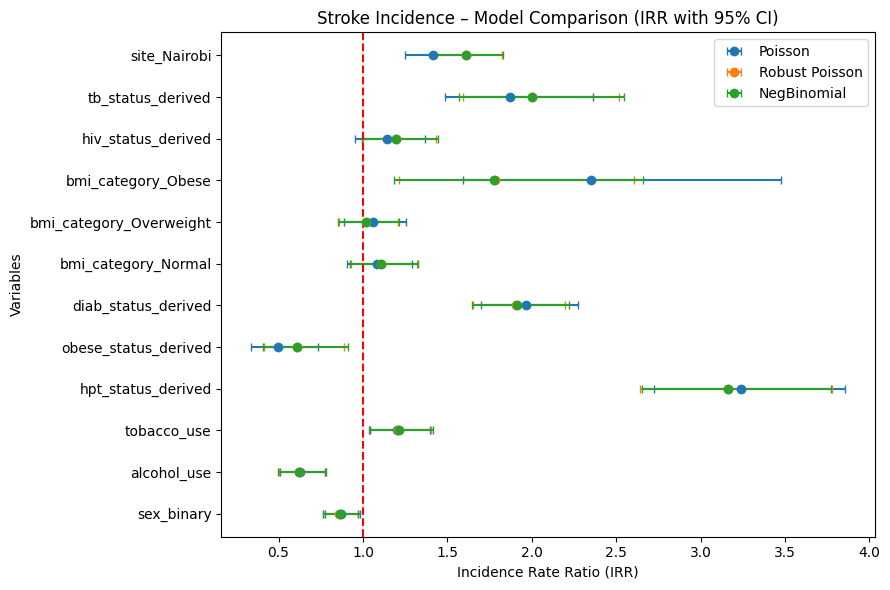

In [578]:
plt.figure(figsize=(9, 6))
for model_name, df_irr in [('Poisson', results_pois),
                       ('Robust Poisson', results_robust),
                       ('NegBinomial', results_nb)]:
    plot_df = df_irr[df_irr["Variable"] != "const"]
    plt.errorbar(
        plot_df["IRR"], plot_df["Variable"],
        xerr=[plot_df["IRR"] - plot_df["IRR_CI_lower"], 
              plot_df["IRR_CI_upper"] - plot_df["IRR"]],
        fmt='o', capsize=3, label=model_name
    )

plt.axvline(1, color='red', linestyle='--')
plt.xlabel("Incidence Rate Ratio (IRR)")
plt.ylabel("Variables")
plt.title("Stroke Incidence – Model Comparison (IRR with 95% CI)")
plt.legend()
plt.tight_layout()
plt.savefig('D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/visualization/stroke_model_comparison.png', dpi=300)
plt.show()

#### Second visual

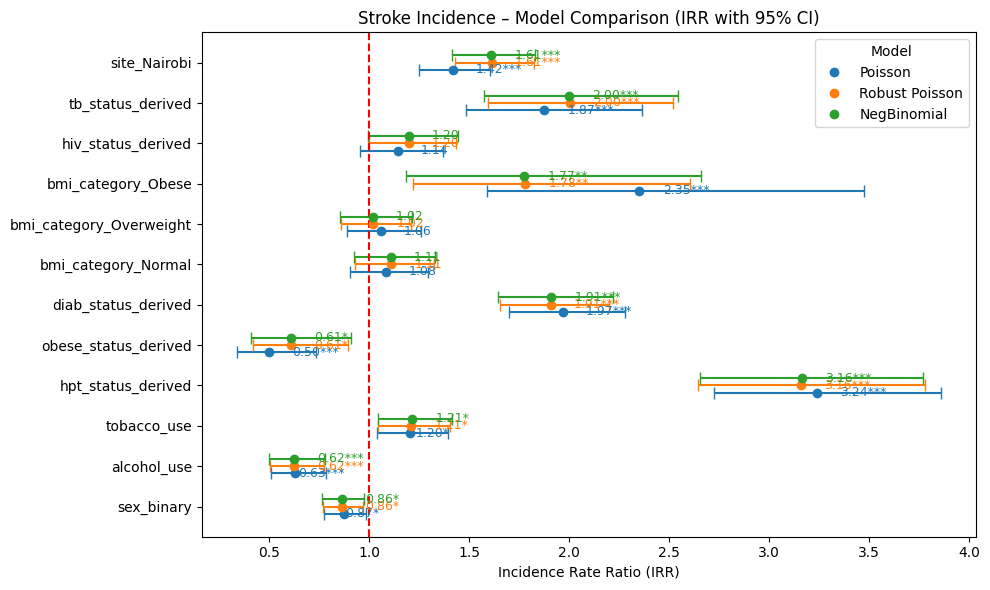

Saved: stroke_model_comparison_annotated_fixed.png


In [579]:
import numpy as np
import matplotlib.pyplot as plt

# --- prepare a base variable order (use Poisson result as reference) ---
varlist = results_pois.loc[results_pois["Variable"] != "const", "Variable"].tolist()
n_vars = len(varlist)
base_y = np.arange(n_vars)

# vertical offsets so the 3 model points don't overlap
y_offsets = {
    'Poisson': -0.18,
    'Robust Poisson': 0.0,
    'NegBinomial': 0.18
}

colors = {
    'Poisson': '#1f77b4',
    'Robust Poisson': '#ff7f0e',
    'NegBinomial': '#2ca02c'
}

plt.figure(figsize=(10, 6))

# loop over models and plot
for model_name, df_irr in [
    ('Poisson', results_pois),
    ('Robust Poisson', results_robust),
    ('NegBinomial', results_nb)
]:
    # align to varlist so positions are consistent
    df_aligned = df_irr.set_index('Variable').reindex(varlist).reset_index()

    for j, row in df_aligned.iterrows():
        # skip variables with missing estimates
        if pd.isna(row['IRR']):
            continue

        y = base_y[j] + y_offsets[model_name]

        # compute left/right error for errorbar
        left = row['IRR'] - row['IRR_CI_lower']
        right = row['IRR_CI_upper'] - row['IRR']

        # Plot errorbar and point
        plt.errorbar(
            x=row['IRR'],
            y=y,
            xerr=np.array([[left], [right]]),
            fmt='o',
            capsize=4,
            color=colors[model_name],
            label=None  # legend handled below
        )

        # Add IRR text + significance star to the right of the point
        text_offset = 0.03 * (plt.xlim()[1] - plt.xlim()[0]) if plt.xlim()[1] > plt.xlim()[0] else 0.05
        # to avoid referencing plt.xlim() before any points are drawn, use a small constant fallback:
        if text_offset == 0:
            text_offset = 0.05
        plt.text(row['IRR'] + text_offset, y, f'{row["IRR"]:.2f}{row.get("sig","")}',
                 fontsize=9, color=colors[model_name], va='center')

# Add a manual legend (one marker per model)
for mn, color in colors.items():
    plt.plot([], [], 'o', color=color, label=mn)
plt.legend(title='Model')

# y-ticks and labels
plt.yticks(base_y, varlist)
plt.axvline(1, color='red', linestyle='--')
plt.xlabel("Incidence Rate Ratio (IRR)")
plt.title("Stroke Incidence – Model Comparison (IRR with 95% CI)")
plt.tight_layout()

# Save and show
plt.savefig('D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/visualization/stroke_model_comparison_annotated_fixed.png', dpi=300)
plt.show()
print("Saved: stroke_model_comparison_annotated_fixed.png")

### Checking for overdispersion

In [580]:
dispersion = model_pois.deviance / model_pois.df_resid
print("Dispersion parameter:", dispersion)

if dispersion > 1.5:
    print("⚠️ Data likely overdispersed — Negative Binomial model may be more appropriate.")
else:
    print("✅ Poisson model dispersion acceptable.")

Dispersion parameter: 0.17732367122877385
✅ Poisson model dispersion acceptable.


In [581]:
# model_pois, model_robust, model_nb
pearson_chi2 = sum(model.resid_pearson**2)
df_resid = model.df_resid
dispersion = pearson_chi2 / df_resid
print("Dispersion - model:", dispersion)

Dispersion - model: 0.9999999999999626


### Best Perfoming Model - Negative Binomial model

#### Grouping Variables

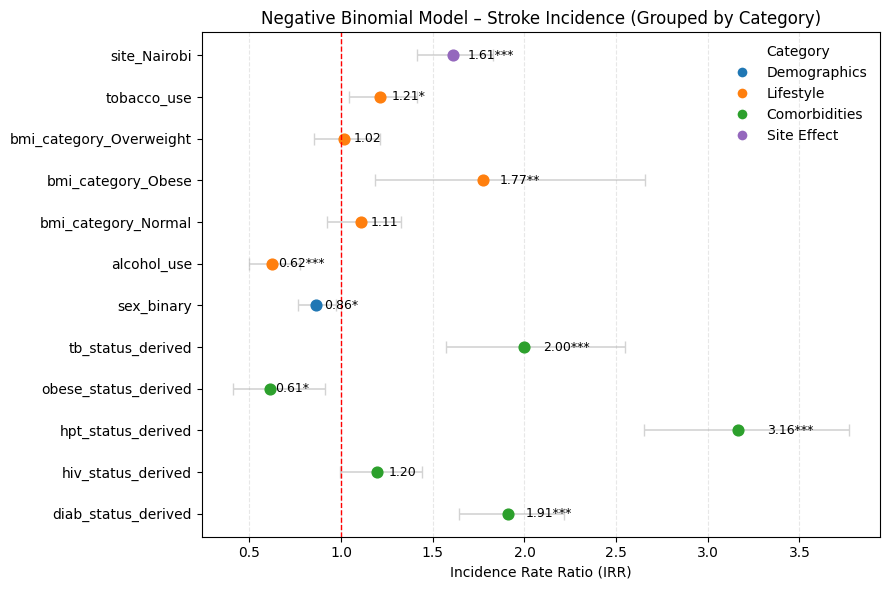

✅ Saved: D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/visualization/stroke_model_nb_grouped.png


In [582]:
import matplotlib.pyplot as plt
import numpy as np

# Drop rows with missing confidence intervals
plot_df = plot_df.dropna(subset=["IRR", "IRR_CI_lower", "IRR_CI_upper"]).copy()

# Define conceptual categories
category_map = {
    'sex_binary': 'Demographics',
    'alcohol_use': 'Lifestyle',
    'tobacco_use': 'Lifestyle',
    'bmi_category_Normal': 'Lifestyle', 
    'bmi_category_Overweight': 'Lifestyle', 
    'bmi_category_Obese': 'Lifestyle',
    'obese_status_derived': 'Comorbidities',
    'hpt_status_derived': 'Comorbidities',
    'diab_status_derived': 'Comorbidities',
    'hiv_status_derived': 'Comorbidities',
    'tb_status_derived': 'Comorbidities',
    'site_Nairobi': 'Site Effect'
}

# Define category colors
category_colors = {
    'Demographics': '#1f77b4',   # blue
    'Lifestyle': '#ff7f0e',      # orange
    'Comorbidities': '#2ca02c',  # green
    'Site Effect': '#9467bd'     # purple
}

# Assign category and color
plot_df['Category'] = plot_df['Variable'].map(category_map)
plot_df['Color'] = plot_df['Category'].map(category_colors).fillna('#999999')

# Sort by category and variable
plot_df = plot_df.sort_values(by=['Category', 'Variable'], ascending=True).reset_index(drop=True)

# Compute symmetric error bars
xerr = np.array([
    plot_df["IRR"] - plot_df["IRR_CI_lower"],
    plot_df["IRR_CI_upper"] - plot_df["IRR"]
])

# --- PLOT ---
plt.figure(figsize=(9, 6))

# Plot CIs
plt.errorbar(
    x=plot_df["IRR"],
    y=np.arange(len(plot_df)),
    xerr=xerr,
    fmt='o',
    capsize=4,
    color='gray',
    ecolor='lightgray',
    elinewidth=1.2,
    zorder=1
)

# Plot colored points + annotations
for idx, (_, row) in enumerate(plot_df.iterrows()):
    plt.scatter(row["IRR"], idx, color=row["Color"], s=60, zorder=2)
    irr_text = f'{row["IRR"]:.2f}'
    if "sig" in row and isinstance(row["sig"], str):
        irr_text += row["sig"]
    plt.text(row["IRR"] * 1.05, idx, irr_text, va='center', fontsize=9, color='black')

# Reference line
plt.axvline(1, color='red', linestyle='--', linewidth=1)

# Axis and labels
plt.yticks(np.arange(len(plot_df)), plot_df["Variable"])
plt.xlabel("Incidence Rate Ratio (IRR)")
plt.title("Negative Binomial Model – Stroke Incidence (Grouped by Category)")

# --- Legend in top-right corner ---
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=cat,
               markerfacecolor=color, markersize=8)
    for cat, color in category_colors.items()
]
plt.legend(handles=handles, title="Category", loc='upper right',
           bbox_to_anchor=(1, 1), frameon=False)
# plt.legend(title="Effect Direction", loc="upper right", frameon=True)

# Layout and aesthetics
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Save and show
output_path = (
    'D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/'
    'stroke_work/visualization/stroke_model_nb_grouped.png'
)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved: {output_path}")

### Diagnostic Checklist

In [583]:
import numpy as np
import statsmodels.api as sm

# --- Assume you already have ---
# df        : your analysis dataset
# y         : dependent variable (stroke events: 0/1)
# X         : independent variables (already with constant)
# person_time : person-years (numeric)

# Fit standard Poisson model
model_pois = sm.GLM(y, X, family=sm.families.Poisson(), offset=df["offset"]).fit()

# Check for overdispersion
dispersion = model_pois.pearson_chi2 / model_pois.df_resid
print(f"\nDispersion = {dispersion:.2f}")

if dispersion < 1.5:
    print("✅ Dispersion looks acceptable. Poisson assumptions roughly OK.")
else:
    print("⚠️ Overdispersion detected — variance > mean. Consider Robust or Negative Binomial model.\n")

# Fit Robust Poisson (same coefficients, larger SEs)
model_robust = sm.GLM(y, X, family=sm.families.Poisson(), offset=df["offset"]).fit(cov_type='HC0')

# Fit Negative Binomial
model_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(), offset=df["offset"]).fit()

# Compare model performance
comparison = {
    "Model": ["Poisson", "Robust Poisson", "Negative Binomial"],
    "AIC": [model_pois.aic, model_robust.aic, model_nb.aic],
    "Deviance/df": [
        dispersion,
        model_robust.pearson_chi2 / model_robust.df_resid,
        model_nb.pearson_chi2 / model_nb.df_resid,
    ],
}

import pandas as pd
results_df = pd.DataFrame(comparison)
print("\n--- Model Comparison ---")
print(results_df)

# Recommendation rule
if model_nb.aic < model_pois.aic * 0.99:
    print("\n✅ Negative Binomial provides better fit (lower AIC, handles overdispersion).")
elif dispersion > 1.5:
    print("\n✅ Use Robust Poisson: similar IRRs, corrected SEs.")
else:
    print("\n✅ Poisson model adequate for inference.")

TypeError: len() of unsized object